In [1]:
# 1. Bibliotekų importavimas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import requests
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Nustatome grafikų stilių
plt.style.use('ggplot')

In [ ]:
# 2. Duomenų gavimas iš Binance API
# Naudojame tą pačią funkciją, kaip ir ankstesniuose modeliuose

def gauti_bitcoin_duomenis(dienu_skaicius=730):
    """
    Gauna Bitcoin kainos duomenis per pasirinktą dienų skaičių iš Binance
    
    Args:
        dienu_skaicius: Kiek praeities dienų įtraukti
    
    Returns:
        pandas DataFrame su kainų duomenimis
    """
    # Apskaičiuojame pradžios laiko žymą (timestamp) milisekundėmis
    pabaigos_data = datetime.now()
    pradzios_data = pabaigos_data - timedelta(days=dienu_skaicius)
    
    # Konvertuojame į UNIX laiko žymą milisekundėmis
    pradzios_ms = int(pradzios_data.timestamp() * 1000)
    
    # Binance API URL - naudojame dienos (1d) laiko intervalą BTCUSDT simboliui
    url = "https://api.binance.com/api/v3/klines"
    
    # Parametrai užklausai
    params = {
        "symbol": "BTCUSDT",     # Bitcoin/USDT pora
        "interval": "1d",        # Dieninis intervalas
        "startTime": pradzios_ms, # Pradžios laikas
        "limit": 1000            # Maksimalus įrašų skaičius (Binance limitas)
    }
    
    print(f"Gaunami Bitcoin duomenys nuo {pradzios_data.strftime('%Y-%m-%d')} iki {pabaigos_data.strftime('%Y-%m-%d')}...")
    
    try:
        # Siunčiame užklausą į Binance API
        atsakymas = requests.get(url, params=params)
        
        # Tikriname, ar užklausa sėkminga
        if atsakymas.status_code == 200:
            duomenys = atsakymas.json()
            
            # Sukuriame DataFrame su reikiamais stulpeliais
            df = pd.DataFrame(duomenys, columns=[
                'atidarymo_laikas', 'atidarymo_kaina', 'auksciausia', 'zemiausia', 
                'uzdarymo_kaina', 'apyvarta', 'uzdarymo_laikas', 'apyvarta_quote', 
                'sandoriu_skaicius', 'aktyvaus_pirkimo_apyvarta', 
                'aktyvaus_pirkimo_apyvarta_quote', 'ignoruoti'
            ])
            
            # Konvertuojame laiko žymas į datetime ir kainų stulpelius į float
            df['atidarymo_laikas'] = pd.to_datetime(df['atidarymo_laikas'], unit='ms')
            df['uzdarymo_laikas'] = pd.to_datetime(df['uzdarymo_laikas'], unit='ms')
            df['uzdarymo_kaina'] = df['uzdarymo_kaina'].astype(float)
            
            # Nustatome datą kaip indeksą
            df = df.set_index('atidarymo_laikas')
            
            # Išrenkame tik uždarymo kainą ir pervadinkime stulpelį
            bitcoin_df = df[['uzdarymo_kaina']].copy()
            bitcoin_df = bitcoin_df.rename(columns={'uzdarymo_kaina': 'kaina'})
            
            print(f"Sėkmingai gauti {len(bitcoin_df)} dienų duomenys.")
            return bitcoin_df
            
        else:
            print(f"Klaida gaunant duomenis iš Binance. Statusas: {atsakymas.status_code}")
            print(f"Atsakymas: {atsakymas.text}")
            return None
            
    except Exception as e:
        print(f"Klaida: {str(e)}")
        return None

# Gauname duomenis už pastaruosius 2 metus (730 dienų)
bitcoin_df = gauti_bitcoin_duomenis(730)

# Patikriname, kaip atrodo duomenys
print("Pirmieji įrašai:")
print(bitcoin_df.head())

# Patikriname, ar yra trūkstamų reikšmių
print("\nTrūkstamų reikšmių skaičius:")
print(bitcoin_df.isna().sum())

# Pašaliname trūkstamas reikšmes, jei tokių yra
bitcoin_df = bitcoin_df.dropna()

Gaunami Bitcoin duomenys nuo 2023-05-23 iki 2025-05-22...
Sėkmingai gauti 730 dienų duomenys.
Pirmieji įrašai:
                     kaina
atidarymo_laikas          
2023-05-24        26329.01
2023-05-25        26473.79
2023-05-26        26705.92
2023-05-27        26854.27
2023-05-28        28065.00

Trūkstamų reikšmių skaičius:
kaina    0
dtype: int64


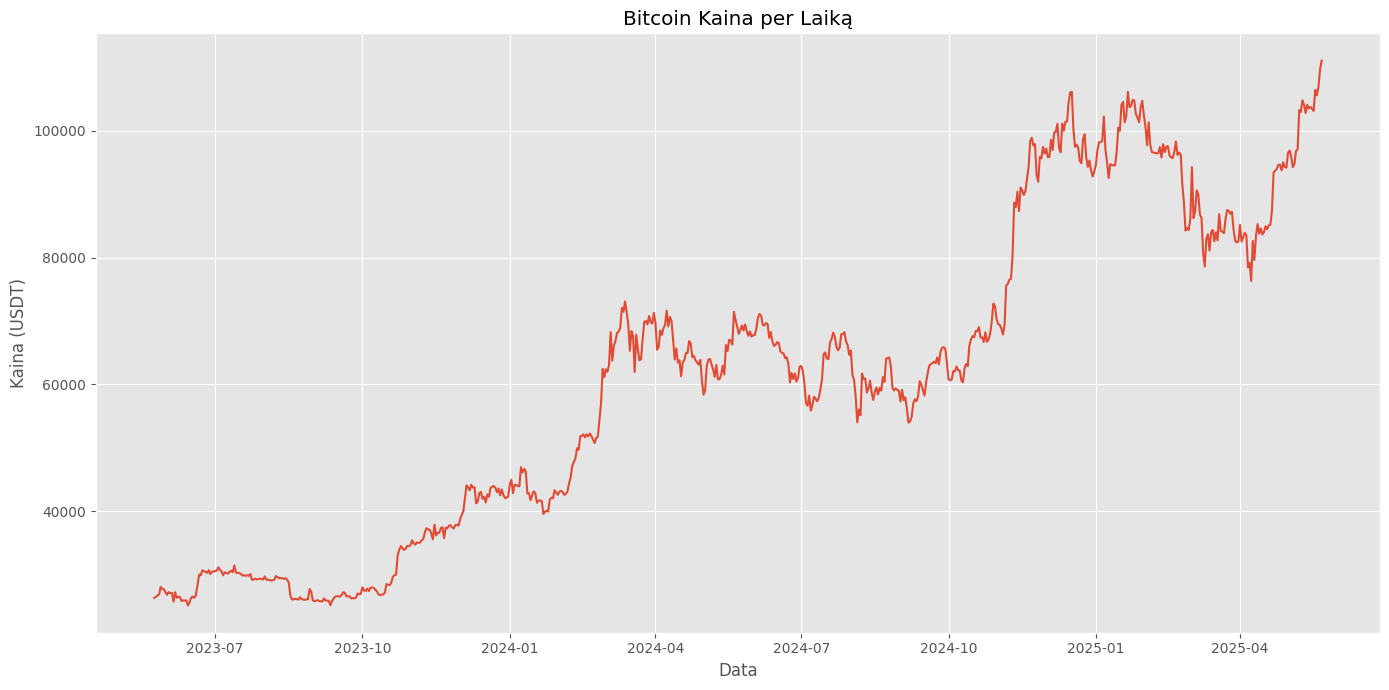


Pagrindinė statistika:
               kaina
count     730.000000
mean    60773.157877
std     24752.687158
min     25128.600000
25%     37418.112500
50%     62349.990000
75%     82568.400000
max    111064.770000

Stacionarumo testas originaliai kainų eilutei:
ADF testo p-reikšmė: 0.936499
Kritinės reikšmės:
	1%: -3.439
	5%: -2.866
	10%: -2.569
Išvada: Duomenys nėra stacionarūs (negalime atmesti nulinės hipotezės)


In [3]:
# 3. Duomenų vizualizacija ir laiko eilutės charakteristikų analizė

# Pavaizduojame Bitcoin kainos istoriją
plt.figure(figsize=(14, 7))
plt.plot(bitcoin_df.index, bitcoin_df['kaina'])
plt.title('Bitcoin Kaina per Laiką')
plt.xlabel('Data')
plt.ylabel('Kaina (USDT)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Pagrindinė statistika
print("\nPagrindinė statistika:")
print(bitcoin_df.describe())

# Patikriname, ar duomenys yra stacionarūs naudojant Augmented Dickey-Fuller testą
def patikrinti_stacionaruma(laiko_eilute):
    """
    Patikrina, ar laiko eilutė yra stacionari naudojant Augmented Dickey-Fuller testą
    
    Args:
        laiko_eilute: DataFrame stulpelis su laiko eilutės duomenimis
    
    Returns:
        bool: True jei stacionari, False jei ne
    """
    # Atliekame ADF testą
    adf_rezultatas = adfuller(laiko_eilute.dropna())
    
    # Išspausdiname rezultatus
    print('ADF testo p-reikšmė: %f' % adf_rezultatas[1])
    print('Kritinės reikšmės:')
    for reiksme, kritine_reiksme in adf_rezultatas[4].items():
        print('\t%s: %.3f' % (reiksme, kritine_reiksme))
    
    # Jei p-reikšmė mažesnė už 0.05, atmetame nulinę hipotezę, kad duomenys nėra stacionarūs
    if adf_rezultatas[1] <= 0.05:
        print("Išvada: Duomenys yra stacionarūs (atmetame nulinę hipotezę)")
        return True
    else:
        print("Išvada: Duomenys nėra stacionarūs (negalime atmesti nulinės hipotezės)")
        return False

print("\nStacionarumo testas originaliai kainų eilutei:")
yra_stacionaru = patikrinti_stacionaruma(bitcoin_df['kaina'])


Taikome diferencijavimą, kad gautume stacionarią eilutę...


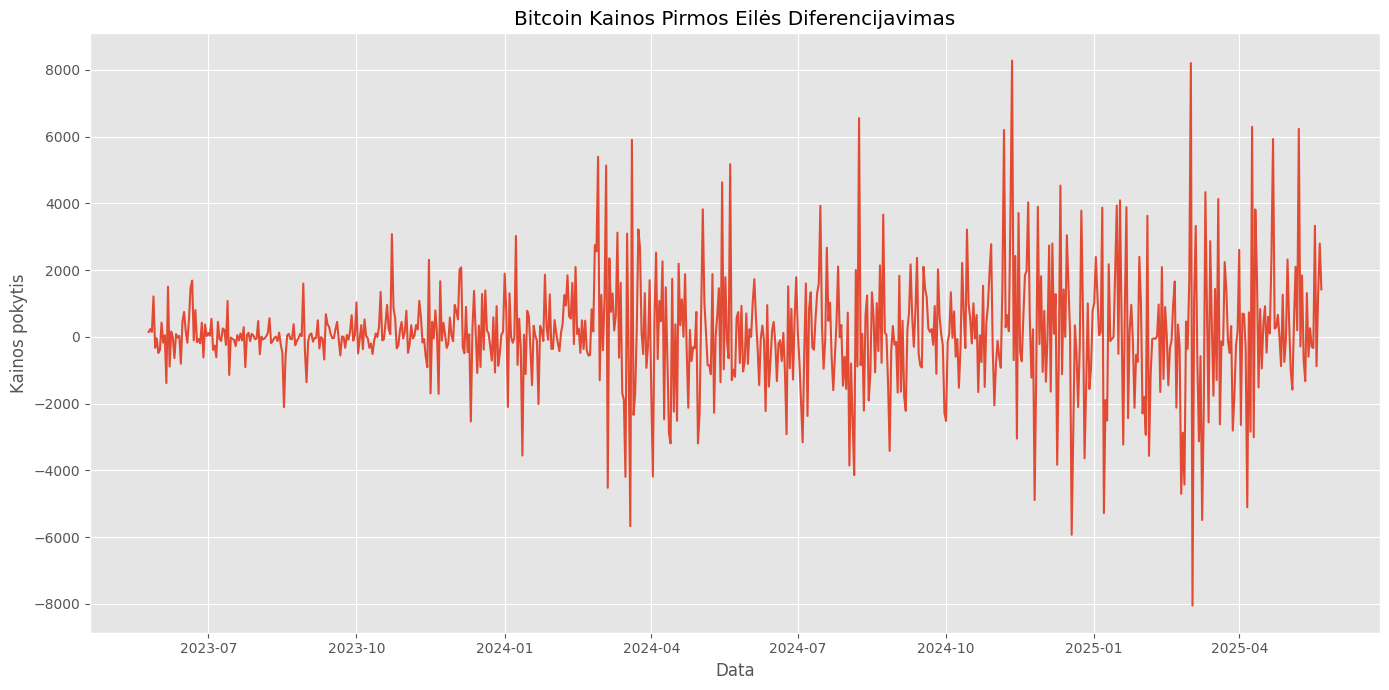


Stacionarumo testas diferencijuotai eilutei:
ADF testo p-reikšmė: 0.000000
Kritinės reikšmės:
	1%: -3.439
	5%: -2.866
	10%: -2.569
Išvada: Duomenys yra stacionarūs (atmetame nulinę hipotezę)


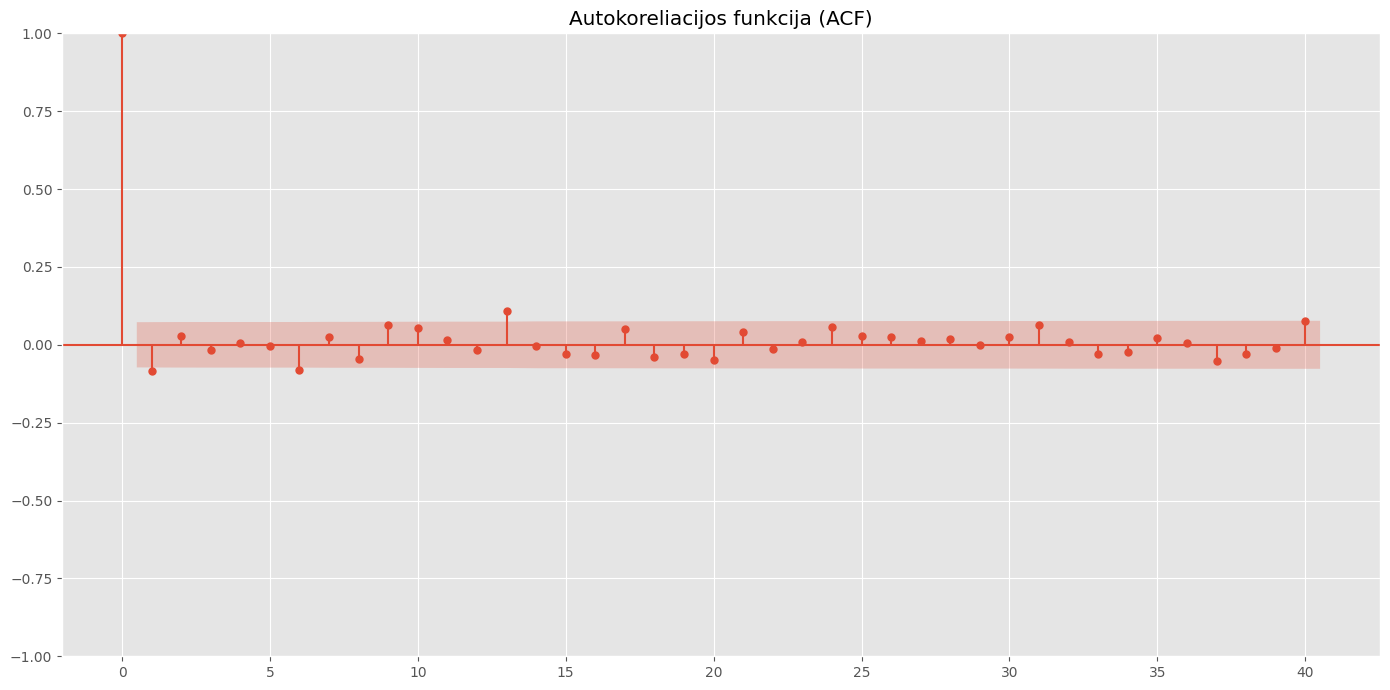

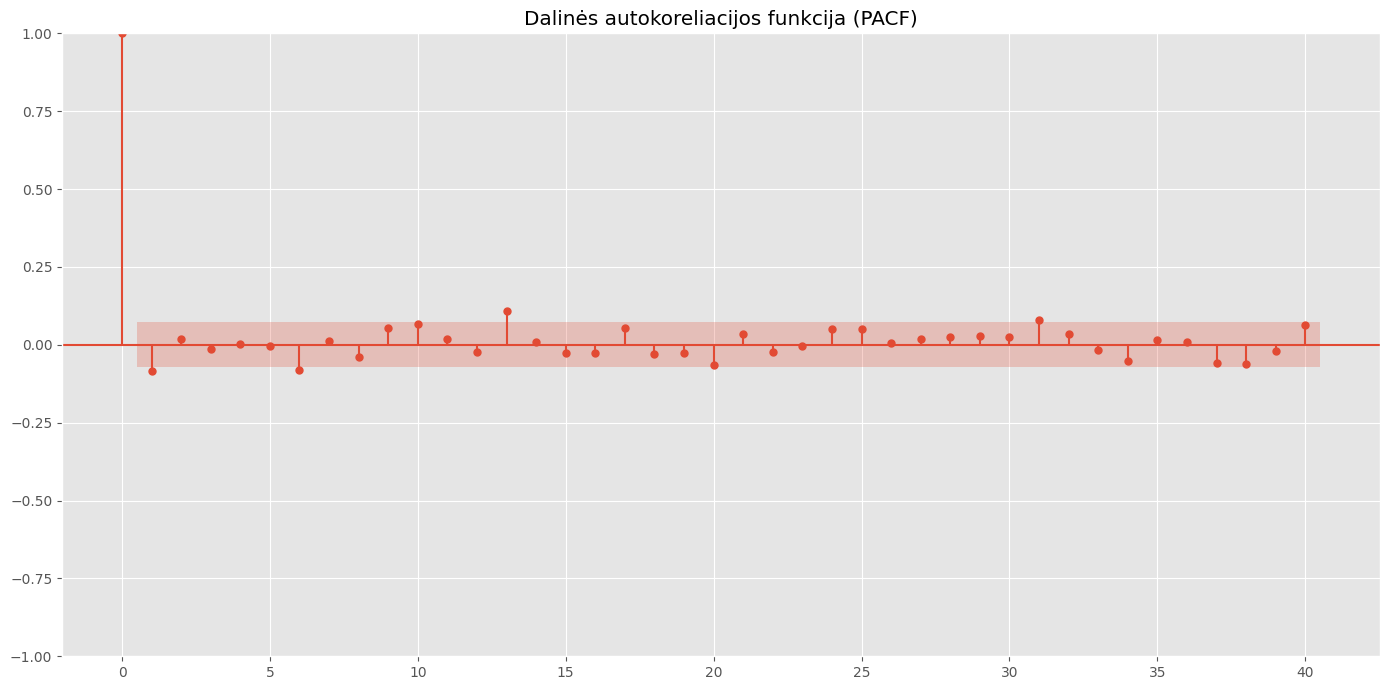

Diferencijavimo eilė (d parametras ARIMA modeliui): 1


In [4]:
# 4. Duomenų transformavimas į stacionarią eilutę

# Jei duomenys nėra stacionarūs, taikome diferencijavimą
if not yra_stacionaru:
    print("\nTaikome diferencijavimą, kad gautume stacionarią eilutę...")
    
    # Pirmos eilės diferencijavimas (kainos pokyčiai)
    bitcoin_df['kaina_diff1'] = bitcoin_df['kaina'].diff()
    
    # Pašaliname pirmą eilutę, kur yra NaN po diferencijavimo
    bitcoin_df = bitcoin_df.dropna()
    
    # Pavaizduojame diferencijuotą eilutę
    plt.figure(figsize=(14, 7))
    plt.plot(bitcoin_df.index, bitcoin_df['kaina_diff1'])
    plt.title('Bitcoin Kainos Pirmos Eilės Diferencijavimas')
    plt.xlabel('Data')
    plt.ylabel('Kainos pokytis')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Tikriname, ar diferencijuota eilutė yra stacionari
    print("\nStacionarumo testas diferencijuotai eilutei:")
    yra_stacionaru_diff = patikrinti_stacionaruma(bitcoin_df['kaina_diff1'])
    
    # Jei vis dar nėra stacionaru, taikome antrą diferencijavimą
    if not yra_stacionaru_diff:
        print("\nTaikome antrą diferencijavimą...")
        bitcoin_df['kaina_diff2'] = bitcoin_df['kaina_diff1'].diff()
        bitcoin_df = bitcoin_df.dropna()
        
        # Pavaizduojame antrą kartą diferencijuotą eilutę
        plt.figure(figsize=(14, 7))
        plt.plot(bitcoin_df.index, bitcoin_df['kaina_diff2'])
        plt.title('Bitcoin Kainos Antros Eilės Diferencijavimas')
        plt.xlabel('Data')
        plt.ylabel('Kainos pokyčio pokytis')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        print("\nStacionarumo testas antrą kartą diferencijuotai eilutei:")
        patikrinti_stacionaruma(bitcoin_df['kaina_diff2'])

# Vizualizuojame autokoreliacijos funkcijas, kurios padės nustatyti ARIMA parametrus
if 'kaina_diff2' in bitcoin_df.columns:
    eilute_analizei = bitcoin_df['kaina_diff2']
    d_verte = 2
elif 'kaina_diff1' in bitcoin_df.columns:
    eilute_analizei = bitcoin_df['kaina_diff1']
    d_verte = 1
else:
    eilute_analizei = bitcoin_df['kaina']
    d_verte = 0

# Autokoreliacijos grafikas (ACF)
plt.figure(figsize=(14, 7))
plot_acf(eilute_analizei, lags=40, ax=plt.gca())
plt.title('Autokoreliacijos funkcija (ACF)')
plt.tight_layout()
plt.show()

# Dalinės autokoreliacijos grafikas (PACF)
plt.figure(figsize=(14, 7))
plot_pacf(eilute_analizei, lags=40, ax=plt.gca())
plt.title('Dalinės autokoreliacijos funkcija (PACF)')
plt.tight_layout()
plt.show()

print(f"Diferencijavimo eilė (d parametras ARIMA modeliui): {d_verte}")

In [5]:
# 5. ARIMA modelio parametrų nustatymas ir modelio apmokymas

# Padalijame duomenis į mokymo ir testavimo rinkinius
mokymui_proc = 0.8  # 80% duomenų skiriame mokymui
mokymo_dydis = int(len(bitcoin_df) * mokymui_proc)

# Mokymo ir testavimo duomenys
train_data = bitcoin_df.iloc[:mokymo_dydis]
test_data = bitcoin_df.iloc[mokymo_dydis:]

print(f"Mokymo duomenų dydis: {len(train_data)}")
print(f"Testavimo duomenų dydis: {len(test_data)}")

# Remiantis ACF ir PACF grafikais, nustatome pradinius p ir q parametrus
# Paprastai p parametras nustatomas pagal PACF, o q pagal ACF
# Tai tik pradiniai parametrai, kuriuos toliau optimizuosime
p_pradinis = 1  # AR parametras
d_parametras = d_verte  # Diferencijavimo eilė, nustatyta anksčiau
q_pradinis = 1  # MA parametras

print(f"\nPradiniai ARIMA parametrai: p={p_pradinis}, d={d_parametras}, q={q_pradinis}")

# Išbandysime keletą ARIMA modelių su skirtingais parametrais
p_reiksmes = range(0, 3)  # AR parametrai
q_reiksmes = range(0, 3)  # MA parametrai

geriausi_parametrai = None
geriausias_aic = float('inf')
geriausias_modelis = None

print("\nIeškome geriausių ARIMA parametrų pagal AIC kriterijų...")

for p in p_reiksmes:
    for q in q_reiksmes:
        try:
            # ARIMA modelio sukūrimas ir pritaikymas mokymo duomenims
            if d_parametras == 0:
                # Jei d=0, naudojame originalią kainų eilutę
                model = ARIMA(train_data['kaina'], order=(p, d_parametras, q))
            elif d_parametras == 1:
                # Jei d=1, naudojame kartą diferencijuotą eilutę
                model = ARIMA(train_data['kaina_diff1'], order=(p, 0, q))
            else:  # d=2
                # Jei d=2, naudojame du kartus diferencijuotą eilutę
                model = ARIMA(train_data['kaina_diff2'], order=(p, 0, q))
                
            model_fit = model.fit()
            
            # Skaičiuojame AIC - mažesnis AIC reiškia geresnį modelį
            aic = model_fit.aic
            
            print(f"ARIMA({p}, {d_parametras}, {q}) - AIC: {aic:.2f}")
            
            if aic < geriausias_aic:
                geriausias_aic = aic
                geriausi_parametrai = (p, d_parametras, q)
                geriausias_modelis = model_fit
                
        except Exception as e:
            print(f"Klaida su ARIMA({p}, {d_parametras}, {q}): {str(e)}")

print(f"\nGeriausi ARIMA parametrai: p={geriausi_parametrai[0]}, d={geriausi_parametrai[1]}, q={geriausi_parametrai[2]}")
print(f"Geriausio modelio AIC: {geriausias_aic:.2f}")

# Modelio santrauka
print("\nGeriausio ARIMA modelio santrauka:")
print(geriausias_modelis.summary())

Mokymo duomenų dydis: 583
Testavimo duomenų dydis: 146

Pradiniai ARIMA parametrai: p=1, d=1, q=1

Ieškome geriausių ARIMA parametrų pagal AIC kriterijų...
ARIMA(0, 1, 0) - AIC: 10193.24
ARIMA(0, 1, 1) - AIC: 10194.21
ARIMA(0, 1, 2) - AIC: 10195.73
ARIMA(1, 1, 0) - AIC: 10194.14
ARIMA(1, 1, 1) - AIC: 10195.16
ARIMA(1, 1, 2) - AIC: 10196.78
ARIMA(2, 1, 0) - AIC: 10195.50
ARIMA(2, 1, 1) - AIC: 10196.82
ARIMA(2, 1, 2) - AIC: 10188.31

Geriausi ARIMA parametrai: p=2, d=1, q=2
Geriausio modelio AIC: 10188.31

Geriausio ARIMA modelio santrauka:
                               SARIMAX Results                                
Dep. Variable:            kaina_diff1   No. Observations:                  583
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -5088.155
Date:                Thu, 22 May 2025   AIC                          10188.311
Time:                        18:33:04   BIC                          10214.520
Sample:                    05-25-2023   HQIC                


Įvertiname ARIMA modelį testavimo rinkinyje...
RMSE (Root Mean Squared Error): 13908.94
MAE (Mean Absolute Error): 11250.05
MAPE (Mean Absolute Percentage Error): 12.81%


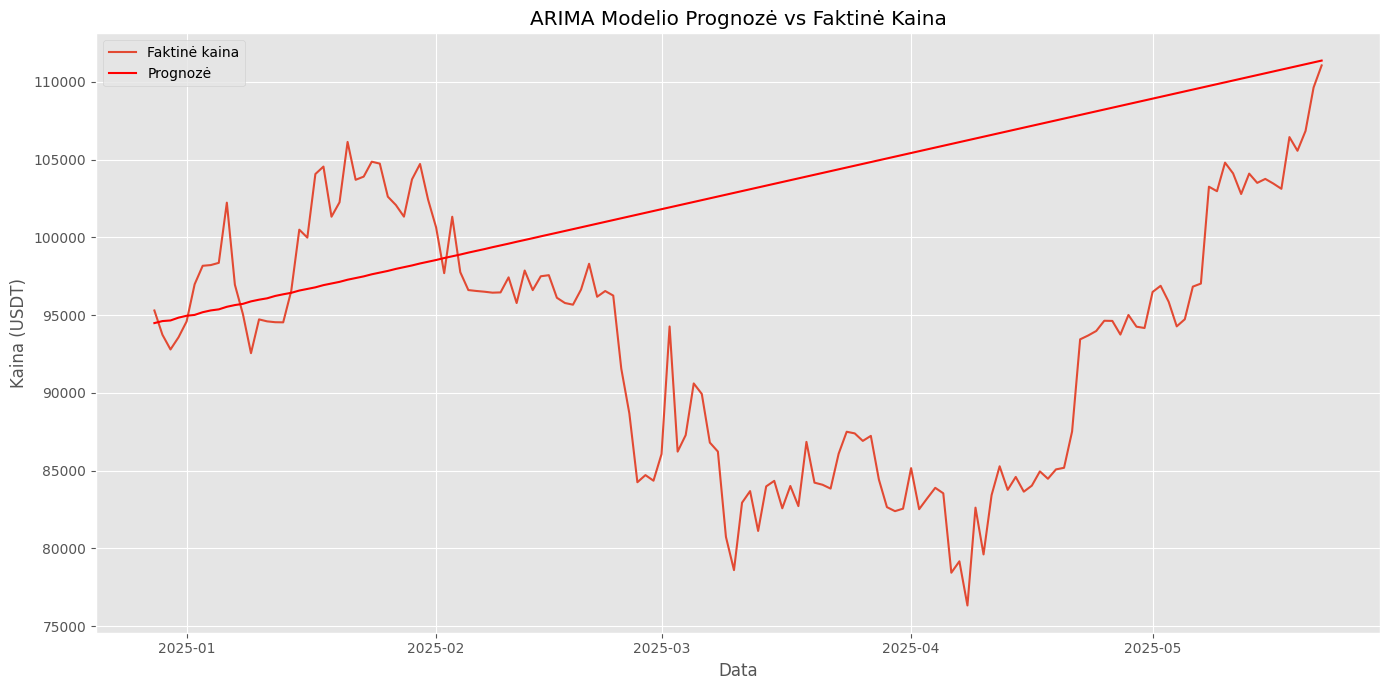

In [6]:
# 6. ARIMA modelio prognozės ir įvertinimas

# Funkcija ARIMA prognozei atlikti
def atlikti_arima_prognoze(modelis, duomenys, d_param, prognozuojamu_dienu_sk=30):
    """
    Atlieka ARIMA prognozę ir transformuoja rezultatus atgal į pradinę skalę
    
    Args:
        modelis: Apmokytas ARIMA modelis
        duomenys: DataFrame su pradiniais duomenimis
        d_param: Diferencijavimo eilė
        prognozuojamu_dienu_sk: Kiek dienų į priekį prognozuoti
    
    Returns:
        DataFrame su prognozėmis
    """
    # Atliekame prognozę diferencijuotoje erdvėje
    prognoze_diff = modelis.forecast(steps=prognozuojamu_dienu_sk)
    
    # Kuriame prognozės DataFrame
    pask_data = duomenys.index[-1]
    prognozes_dates = [pask_data + timedelta(days=i+1) for i in range(prognozuojamu_dienu_sk)]
    prognozes_df = pd.DataFrame(index=prognozes_dates)
    
    # Jei duomenys nebuvo diferencijuoti (d=0), prognozė jau yra kainų skalėje
    if d_param == 0:
        prognozes_df['prognoze'] = prognoze_diff
        return prognozes_df
    
    # Jei duomenys buvo diferencijuoti (d=1 arba d=2), turime transformuoti atgal
    pask_kaina = duomenys['kaina'].iloc[-1]
    
    if d_param == 1:
        # Kaupiame prognozes atgal į kainų skalę
        prognozes = [pask_kaina]
        for pokytis in prognoze_diff:
            nauja_kaina = prognozes[-1] + pokytis
            prognozes.append(nauja_kaina)
        
        prognozes_df['prognoze'] = prognozes[1:]  # Praleidžiame pirmą, nes tai paskutinė žinoma kaina
    
    elif d_param == 2:
        # Paskutinis žinomas pokytis
        pask_pokytis = duomenys['kaina_diff1'].iloc[-1]
        
        # Kaupiame prognozes atgal į kainų skalę
        prognozes = [pask_kaina]
        pokyčiai = [pask_pokytis]
        
        for pokycio_pokytis in prognoze_diff:
            naujas_pokytis = pokyčiai[-1] + pokycio_pokytis
            pokyčiai.append(naujas_pokytis)
            
            nauja_kaina = prognozes[-1] + naujas_pokytis
            prognozes.append(nauja_kaina)
        
        prognozes_df['prognoze'] = prognozes[1:]
    
    return prognozes_df

# Įvertiname modelio tikslumą testavimo rinkinyje
def ivertinti_modeli(modelis, mokymo_duomenys, testavimo_duomenys, d_param):
    """
    Įvertina ARIMA modelio tikslumą testavimo rinkinyje
    
    Args:
        modelis: Apmokytas ARIMA modelis
        mokymo_duomenys: Mokymo duomenų DataFrame
        testavimo_duomenys: Testavimo duomenų DataFrame
        d_param: Diferencijavimo eilė
    
    Returns:
        Prognozės ir faktinių reikšmių palyginimo DataFrame bei metrikos
    """
    # Prognozuojame kiekvienam testavimo taškui
    prognozuojamu_dienu_sk = len(testavimo_duomenys)
    
    # Prognozės atlikimas
    prognozes = atlikti_arima_prognoze(modelis, mokymo_duomenys, d_param, prognozuojamu_dienu_sk)
    
    # Sujungiame prognozes su faktinėmis reikšmėmis
    palyginimas = pd.DataFrame(index=testavimo_duomenys.index)
    palyginimas['faktine'] = testavimo_duomenys['kaina']
    palyginimas['prognoze'] = prognozes['prognoze'].values
    
    # Skaičiuojame tikslumą
    rmse = sqrt(mean_squared_error(palyginimas['faktine'], palyginimas['prognoze']))
    mae = mean_absolute_error(palyginimas['faktine'], palyginimas['prognoze'])
    mape = np.mean(np.abs((palyginimas['faktine'] - palyginimas['prognoze']) / palyginimas['faktine'])) * 100
    
    return palyginimas, rmse, mae, mape

# Įvertiname modelį testavimo rinkinyje
print("\nĮvertiname ARIMA modelį testavimo rinkinyje...")
palyginimas, rmse, mae, mape = ivertinti_modeli(geriausias_modelis, train_data, test_data, geriausi_parametrai[1])

print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

# Vizualizuojame rezultatus
plt.figure(figsize=(14, 7))
plt.plot(palyginimas.index, palyginimas['faktine'], label='Faktinė kaina')
plt.plot(palyginimas.index, palyginimas['prognoze'], label='Prognozė', color='red')
plt.title('ARIMA Modelio Prognozė vs Faktinė Kaina')
plt.xlabel('Data')
plt.ylabel('Kaina (USDT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# 7. Sezoninio SARIMA modelio pritaikymas

# SARIMA modelis įtraukia sezoninius komponentus
# Be p, d, q parametrų, turime P, D, Q (sezoninius) ir s (sezono ilgį)

# Nustatome pradinius sezoninius parametrus
P_pradinis = 1  # Sezoninis AR
D_pradinis = 1  # Sezoninis diferencijavimas
Q_pradinis = 1  # Sezoninis MA
s_pradinis = 7  # Sezono ilgis (7 dienos savaitėje)

print("\nIšbandome SARIMA modelį su sezoniniais komponentais...")
print(f"Pradiniai SARIMA parametrai: p={geriausi_parametrai[0]}, d={geriausi_parametrai[1]}, q={geriausi_parametrai[2]}, P={P_pradinis}, D={D_pradinis}, Q={Q_pradinis}, s={s_pradinis}")

try:
    # Pritaikome SARIMA modelį mokymo duomenims
    sarima_model = SARIMAX(train_data['kaina'], 
                          order=(geriausi_parametrai[0], geriausi_parametrai[1], geriausi_parametrai[2]),
                          seasonal_order=(P_pradinis, D_pradinis, Q_pradinis, s_pradinis))
    
    sarima_fit = sarima_model.fit(disp=False)
    
    print("\nSARIMA modelio santrauka:")
    print(sarima_fit.summary())
    
    # Prognozuojame su SARIMA modeliu
    print("\nAtliekame SARIMA prognozę testavimo rinkinyje...")
    sarima_pred = sarima_fit.get_forecast(steps=len(test_data))
    sarima_pred_mean = sarima_pred.predicted_mean
    
    # Sujungiame prognozes su faktinėmis reikšmėmis
    sarima_comparison = pd.DataFrame(index=test_data.index)
    sarima_comparison['faktine'] = test_data['kaina']
    sarima_comparison['prognoze'] = sarima_pred_mean.values
    
    # Skaičiuojame tikslumą
    sarima_rmse = sqrt(mean_squared_error(sarima_comparison['faktine'], sarima_comparison['prognoze']))
    sarima_mae = mean_absolute_error(sarima_comparison['faktine'], sarima_comparison['prognoze'])
    sarima_mape = np.mean(np.abs((sarima_comparison['faktine'] - sarima_comparison['prognoze']) / sarima_comparison['faktine'])) * 100
    
    print(f"SARIMA RMSE: {sarima_rmse:.2f}")
    print(f"SARIMA MAE: {sarima_mae:.2f}")
    print(f"SARIMA MAPE: {sarima_mape:.2f}%")
    
    # Vizualizuojame SARIMA rezultatus
    plt.figure(figsize=(14, 7))
    plt.plot(sarima_comparison.index, sarima_comparison['faktine'], label='Faktinė kaina')
    plt.plot(sarima_comparison.index, sarima_comparison['prognoze'], label='SARIMA prognozė', color='green')
    plt.title('SARIMA Modelio Prognozė vs Faktinė Kaina')
    plt.xlabel('Data')
    plt.ylabel('Kaina (USDT)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Klaida pritaikant SARIMA modelį: {str(e)}")
    print("Bandome su kitokiais sezoniniais parametrais...")
    
    # Jei nepavyko su pradiniais parametrais, išbandome paprastesnį variantą
    try:
        sarima_model = SARIMAX(train_data['kaina'], 
                              order=(geriausi_parametrai[0], geriausi_parametrai[1], geriausi_parametrai[2]),
                              seasonal_order=(1, 0, 1, 7))
        
        sarima_fit = sarima_model.fit(disp=False)
        
        print("\nSARIMA modelio (paprastesnio) santrauka:")
        print(sarima_fit.summary())
        
        # Prognozuojame su paprastesniu SARIMA modeliu
        print("\nAtliekame SARIMA prognozę testavimo rinkinyje...")
        sarima_pred = sarima_fit.get_forecast(steps=len(test_data))
        sarima_pred_mean = sarima_pred.predicted_mean
        
        # Skaičiuojame tikslumą
        sarima_comparison = pd.DataFrame(index=test_data.index)
        sarima_comparison['faktine'] = test_data['kaina']
        sarima_comparison['prognoze'] = sarima_pred_mean.values
        
        sarima_rmse = sqrt(mean_squared_error(sarima_comparison['faktine'], sarima_comparison['prognoze']))
        sarima_mae = mean_absolute_error(sarima_comparison['faktine'], sarima_comparison['prognoze'])
        sarima_mape = np.mean(np.abs((sarima_comparison['faktine'] - sarima_comparison['prognoze']) / sarima_comparison['faktine'])) * 100
        
        print(f"SARIMA RMSE: {sarima_rmse:.2f}")
        print(f"SARIMA MAE: {sarima_mae:.2f}")
        print(f"SARIMA MAPE: {sarima_mape:.2f}%")
        
    except Exception as e2:
        print(f"Nepavyko pritaikyti SARIMA modelio: {str(e2)}")


Išbandome SARIMA modelį su sezoniniais komponentais...
Pradiniai SARIMA parametrai: p=2, d=1, q=2, P=1, D=1, Q=1, s=7
Klaida pritaikant SARIMA modelį: LU decomposition error.
Bandome su kitokiais sezoniniais parametrais...

SARIMA modelio (paprastesnio) santrauka:
                                      SARIMAX Results                                      
Dep. Variable:                               kaina   No. Observations:                  583
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -5085.468
Date:                             Thu, 22 May 2025   AIC                          10184.936
Time:                                     18:33:07   BIC                          10215.501
Sample:                                 05-25-2023   HQIC                         10196.851
                                      - 12-27-2024                                         
Covariance Type:                               opg                                        


Modelių tikslumo palyginimas:
ARIMA RMSE: 13908.94, MAE: 11250.05, MAPE: 12.81%
SARIMA RMSE: 8223.97, MAE: 6768.27, MAPE: 7.50%

SARIMA modelis yra tikslesnis pagal RMSE.

Prognozuojame Bitcoin kainą 30 dienų į priekį naudojant SARIMA modelį...


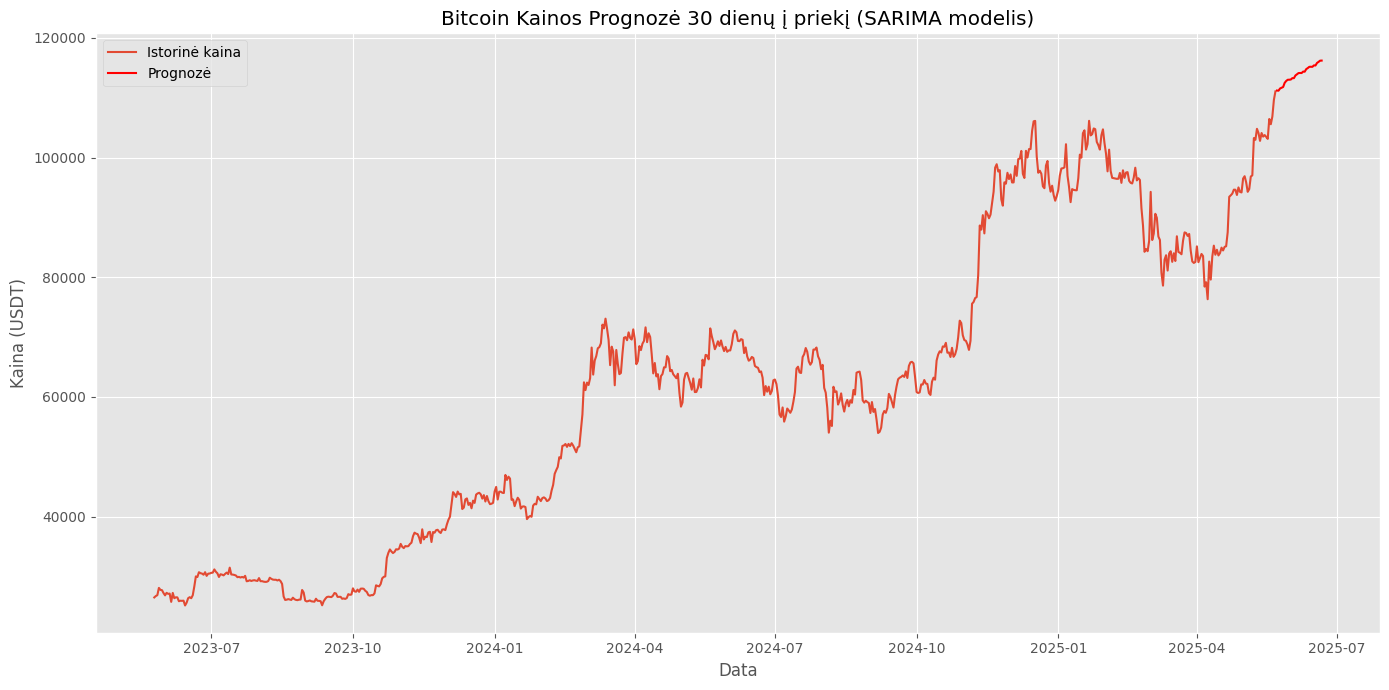


Pirmosios 5 prognozuojamos kainos:
                 prognoze
2025-05-23  111209.047894
2025-05-24  111185.924532
2025-05-25  111551.178684
2025-05-26  111674.258494
2025-05-27  111795.491984


In [8]:
# 8. Modelių palyginimas ir prognozė ateičiai

# Palyginkime ARIMA ir SARIMA (jei pavyko) modelius
print("\nModelių tikslumo palyginimas:")
print(f"ARIMA RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")

if 'sarima_rmse' in locals():
    print(f"SARIMA RMSE: {sarima_rmse:.2f}, MAE: {sarima_mae:.2f}, MAPE: {sarima_mape:.2f}%")
    
    # Nustatome, kuris modelis geresnis pagal RMSE
    if sarima_rmse < rmse:
        print("\nSARIMA modelis yra tikslesnis pagal RMSE.")
        geresnis_modelis = "SARIMA"
        geresnis_modelis_obj = sarima_fit
    else:
        print("\nARIMA modelis yra tikslesnis pagal RMSE.")
        geresnis_modelis = "ARIMA"
        geresnis_modelis_obj = geriausias_modelis
else:
    print("\nTik ARIMA modelio rezultatai prieinami.")
    geresnis_modelis = "ARIMA"
    geresnis_modelis_obj = geriausias_modelis

# Prognozuojame kainas 30 dienų į priekį naudodami geresnį modelį
prognozuojamu_dienu_sk = 30
print(f"\nPrognozuojame Bitcoin kainą {prognozuojamu_dienu_sk} dienų į priekį naudojant {geresnis_modelis} modelį...")

if geresnis_modelis == "ARIMA":
    # Apmokome modelį iš naujo naudodami visus duomenis
    if geriausi_parametrai[1] == 0:
        finalinis_modelis = ARIMA(bitcoin_df['kaina'], order=geriausi_parametrai)
    elif geriausi_parametrai[1] == 1:
        finalinis_modelis = ARIMA(bitcoin_df['kaina_diff1'], order=(geriausi_parametrai[0], 0, geriausi_parametrai[2]))
    else:  # d=2
        finalinis_modelis = ARIMA(bitcoin_df['kaina_diff2'], order=(geriausi_parametrai[0], 0, geriausi_parametrai[2]))
        
    finalinis_fit = finalinis_modelis.fit()
    
    # Atliekame prognozę
    ateities_prognoze = atlikti_arima_prognoze(finalinis_fit, bitcoin_df, geriausi_parametrai[1], prognozuojamu_dienu_sk)
    
else:  # SARIMA
    # Apmokome SARIMA modelį iš naujo naudodami visus duomenis
    try:
        finalinis_modelis = SARIMAX(bitcoin_df['kaina'], 
                                  order=(geriausi_parametrai[0], geriausi_parametrai[1], geriausi_parametrai[2]),
                                  seasonal_order=(P_pradinis, D_pradinis, Q_pradinis, s_pradinis))
    except:
        finalinis_modelis = SARIMAX(bitcoin_df['kaina'], 
                                  order=(geriausi_parametrai[0], geriausi_parametrai[1], geriausi_parametrai[2]),
                                  seasonal_order=(1, 0, 1, 7))
    
    finalinis_fit = finalinis_modelis.fit(disp=False)
    
    # Atliekame prognozę
    sarima_pred_future = finalinis_fit.get_forecast(steps=prognozuojamu_dienu_sk)
    sarima_pred_mean_future = sarima_pred_future.predicted_mean
    
    # Kuriame prognozės DataFrame
    pask_data = bitcoin_df.index[-1]
    prognozes_dates = [pask_data + timedelta(days=i+1) for i in range(prognozuojamu_dienu_sk)]
    ateities_prognoze = pd.DataFrame(index=prognozes_dates)
    ateities_prognoze['prognoze'] = sarima_pred_mean_future.values

# Vizualizuojame istorines kainas ir prognozę
plt.figure(figsize=(14, 7))
plt.plot(bitcoin_df.index, bitcoin_df['kaina'], label='Istorinė kaina')
plt.plot(ateities_prognoze.index, ateities_prognoze['prognoze'], label='Prognozė', color='red')
plt.title(f'Bitcoin Kainos Prognozė {prognozuojamu_dienu_sk} dienų į priekį ({geresnis_modelis} modelis)')
plt.xlabel('Data')
plt.ylabel('Kaina (USDT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Atspausdiname pirmąsias kelias prognozuojamas kainas
print("\nPirmosios 5 prognozuojamos kainos:")
print(ateities_prognoze.head(5))

In [9]:
# 9. Išvados ir modelio vertinimas

# Išvados apie ARIMA/SARIMA modelius
geresnio_modelio_metrikos = (sarima_rmse, sarima_mae, sarima_mape) if geresnis_modelis == "SARIMA" else (rmse, mae, mape)

isvados = f"""
ARIMA/SARIMA Modelių Išvados:

1. Atlikome Bitcoin kainos laiko eilutės analizę ir pritaikėme ARIMA ir SARIMA modelius.

2. Stacionarumo testas parodė, kad {'pradinė laiko eilutė buvo stacionari' if d_verte == 0 else 'reikėjo taikyti diferencijavimą' + (', net du kartus' if d_verte == 2 else '')}.

3. Geriausias ARIMA modelis turėjo parametrus p={geriausi_parametrai[0]}, d={geriausi_parametrai[1]}, q={geriausi_parametrai[2]}.

4. {'SARIMA modelis taip pat buvo sėkmingai pritaikytas, įtraukiant sezoninius komponentus.' if 'sarima_rmse' in locals() else 'SARIMA modelio nepavyko pritaikyti dėl konvergencijos problemų.'}

5. Pagal RMSE, MAE ir MAPE metrikas, {geresnis_modelis} modelis buvo tikslesnis:
   - RMSE: {geresnio_modelio_metrikos[0]:.2f}
   - MAE: {geresnio_modelio_metrikos[1]:.2f}
   - MAPE: {geresnio_modelio_metrikos[2]:.2f}%

6. Prognozavome Bitcoin kainą {prognozuojamu_dienu_sk} dienų į priekį naudodami {geresnis_modelis} modelį.

7. Pagrindiniai pastebėjimai:
   - ARIMA/SARIMA modeliai gerai tinka trumpalaikėms prognozėms.
   - Ilgalaikėms prognozėms (savaitės ar mėnesiai) tikslumas gali reikšmingai sumažėti.
   - Kriptovaliutų rinka yra labai nepastovi ir veikiama daugelio išorinių veiksnių, kurių šie modeliai negali įvertinti.

8. Apribojimai:
   - Modeliai remiasi tik istoriniais duomenimis ir negali įvertinti naujienų, rinkos sentimento ar kitų išorinių veiksnių.
   - Kriptovaliutų kainų pokyčiai dažnai vyksta dėl netikėtų įvykių, kurių modeliai negali numatyti.

9. Tobulinimo galimybės:
   - Pridėti išorinius kintamuosius (pvz., akcijų rinkos indeksus, dolerio kursą, sentimento rodiklius).
   - Išbandyti sudėtingesnius modelius, pvz., LSTM neuroninius tinklus ar hibridines prognozes.
"""

print(isvados)


ARIMA/SARIMA Modelių Išvados:

1. Atlikome Bitcoin kainos laiko eilutės analizę ir pritaikėme ARIMA ir SARIMA modelius.

2. Stacionarumo testas parodė, kad reikėjo taikyti diferencijavimą.

3. Geriausias ARIMA modelis turėjo parametrus p=2, d=1, q=2.

4. SARIMA modelis taip pat buvo sėkmingai pritaikytas, įtraukiant sezoninius komponentus.

5. Pagal RMSE, MAE ir MAPE metrikas, SARIMA modelis buvo tikslesnis:
   - RMSE: 8223.97
   - MAE: 6768.27
   - MAPE: 7.50%

6. Prognozavome Bitcoin kainą 30 dienų į priekį naudodami SARIMA modelį.

7. Pagrindiniai pastebėjimai:
   - ARIMA/SARIMA modeliai gerai tinka trumpalaikėms prognozėms.
   - Ilgalaikėms prognozėms (savaitės ar mėnesiai) tikslumas gali reikšmingai sumažėti.
   - Kriptovaliutų rinka yra labai nepastovi ir veikiama daugelio išorinių veiksnių, kurių šie modeliai negali įvertinti.

8. Apribojimai:
   - Modeliai remiasi tik istoriniais duomenimis ir negali įvertinti naujienų, rinkos sentimento ar kitų išorinių veiksnių.
   - Kriptov